In [1]:
"""vease http://bagustris.blogspot.com/2020ç/06/benchmarking-intel-based-numpy-packages.html"""

'vease http://bagustris.blogspot.com/2020ç/06/benchmarking-intel-based-numpy-packages.html'

In [2]:
#vamos a ejecutar el ejemplo de johansson
#https://nbviewer.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-6B-HPC.ipynb
%load_ext Cython

In [4]:
# prepare some random data
import numpy
import numpy as np
N_core=12
N = 4 * N_core

M = np.random.rand(N, N)
x = np.random.rand(N)
y = np.zeros_like(x)

In [5]:
%timeit numpy.dot(M, x)

4.46 µs ± 8.34 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:

%%cython

cimport cython
cimport numpy
import numpy

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec(numpy.ndarray[numpy.float64_t, ndim=2] M, 
              numpy.ndarray[numpy.float64_t, ndim=1] x, 
              numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x)

    for i from 0 <= i < n:
        for j from 0 <= j < n:
            y[i] += M[i, j] * x[j]
            
    return y

In file included from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/cursofis/.cache/ipython/cython/_cython_magic_58ddae302d1c7d6d2a17708d30726a49.c:649:
/home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


In [15]:
%%cython -f -c-fopenmp --link-args=-fopenmp -c-g

cimport cython
cimport numpy
from cython.parallel import parallel
cimport openmp

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_matvec_omp(numpy.ndarray[numpy.float64_t, ndim=2] M, 
                  numpy.ndarray[numpy.float64_t, ndim=1] x, 
                  numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x), N, r, m

    # release GIL, so that we can use OpenMP
    with nogil, parallel():
        N = openmp.omp_get_num_threads()
        r = openmp.omp_get_thread_num()
        m = n // N  #ojo, quiere usar division entera
        
        for i from 0 <= i < m:
            for j from 0 <= j < n:
                y[r * m + i] += M[r * m + i, j] * x[j]

    return y

In file included from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944,
                 from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/cursofis/.cache/ipython/cython/_cython_magic_3db0baaefb5057db6cf15e190bfda16d.c:655:
/home/cursofis/anaconda3/envs/intel/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it with " \
  ^~~~~~~


In [19]:
import multiprocessing
import time
#N_core = multiprocessing.cpu_count()
N_vec  = numpy.arange(2, 1000, 1)
N_vec  = numpy.append(N_vec,numpy.arange(1000, 3000, 5))
N_vec  = numpy.append(N_vec,numpy.arange(3000, 10000, 500))
N_vec =  numpy.append(N_vec,numpy.arange(10000, 40000, 1000))
duration_ref = numpy.zeros(len(N_vec))
duration_cy = numpy.zeros(len(N_vec))
duration_cy_omp = numpy.zeros(len(N_vec))

for idx, N in enumerate(N_vec):
    
    M = numpy.random.rand(N, N)
    x = numpy.random.rand(N)
    y = numpy.zeros_like(x)
    
    t0 = time.time()
    numpy.dot(M, x)
    duration_ref[idx] = time.time() - t0

    if N < 5000 or N in (1000,3000,10000):
        t0 = time.time()
        cy_matvec(M, x, y)
        duration_cy[idx] = time.time() - t0
    else:
        duration_cy[idx] = numpy.NaN
    
    t0 = time.time()
    cy_matvec_omp(M, x, y)
    duration_cy_omp[idx] = time.time() - t0

Ncores: 24


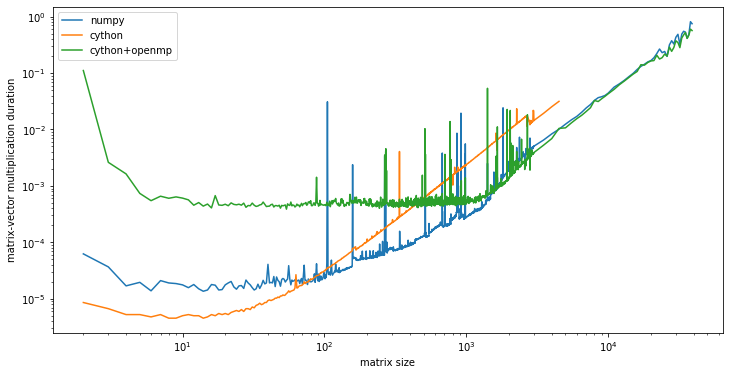

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
print("Ncores:",multiprocessing.cpu_count())
fig, ax = plt.subplots(figsize=(12, 6))

ax.loglog(N_vec, duration_ref, label='numpy')
ax.loglog(N_vec, duration_cy, label='cython')
ax.loglog(N_vec, duration_cy_omp, label='cython+openmp')

ax.legend(loc=2)
ax.set_yscale("log")
ax.set_ylabel("matrix-vector multiplication duration")
ax.set_xlabel("matrix size");

In [21]:
%env CC=icc

env: CC=icc


In [22]:
%%cython

cimport cython
cimport numpy
import numpy

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_icc_matvec(numpy.ndarray[numpy.float64_t, ndim=2] M, 
              numpy.ndarray[numpy.float64_t, ndim=1] x, 
              numpy.ndarray[numpy.float64_t, ndim=1] y):

    cdef int i, j, n = len(x)

    for i from 0 <= i < n:
        for j from 0 <= j < n:
            y[i] += M[i, j] * x[j]
            
    return y

unable to execute 'icc': No such file or directory
